<a href="https://colab.research.google.com/github/Gholamrezadar/chess-piece-classification/blob/main/GHD_Chess_Piece_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my attempt at solving a multiclass classification problem with limited data(~100 images per class, 6 classes).

Gholamreza Dar May 2024

Dataset link:https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset

## Imports and setups

In [1]:
!pip install -qq kaggle lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 20.7 MB/s eta 0:00:00


In [2]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader

import pytorch_lightning as pl

from torchmetrics import Accuracy

In [4]:
DATASET_PATH = "data/Chessman-image-dataset/Chess"
# assert os.path.isdir(DATASET_PATH), "Dataset doesn't exist."

# Set the height and width based on the model you are using
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

# Dataset splits
TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.1
TEST_SPLIT = 0.2

# DataLoader
BATCH_SIZE = 16
NUM_WORKERS = 2

SEED = 42
set_manual_seed(SEED)

NameError: name 'set_manual_seed' is not defined

## Utils

In [5]:
def ram_usage(variable):
    size_in_bytes = sys.getsizeof(variable)
    if size_in_bytes < 1024:
        print(f"RAM usage: {size_in_bytes} bytes")
    elif size_in_bytes < 1024 * 1024:
        print(f"RAM usage: {size_in_bytes / 1024:.2f} KB")
    else:
        print(f"RAM usage: {size_in_bytes / (1024 * 1024):.2f} MB")

In [6]:
def set_manual_seed(seed_value):
    # Set seed for NumPy
    np.random.seed(seed_value)

    # Set seed for PyTorch on CPU
    torch.manual_seed(seed_value)

    # Set seed for PyTorch on GPU if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set seed for Python's random module
    random.seed(seed_value)

## Download dataset

In [7]:
# upload 'kaggle.json' file
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [8]:
# move 'kaggle.json' to '~/.kaggle/kaggle.json' because the kaggle library
# expects it to be there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Download the dataset
!kaggle datasets download -d niteshfre/chessman-image-dataset

Dataset URL: https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset
License(s): other
 57% 33.0M/57.6M [00:00<00:00, 96.4MB/s]
100% 57.6M/57.6M [00:00<00:00, 121MB/s] 


In [10]:
# Unzip the dataset
!mkdir data
!unzip chessman-image-dataset.zip -d ./data

Archive:  chessman-image-dataset.zip
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000000.JPG  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000001.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000002.JPG  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000003.png  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000004.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000006.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000007.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000008.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000009.png  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000010.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000011.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000012.jpg  
  inflating: ./data/Chessman-image-dataset/Chess/Bishop/00000013.jpg  
  inflating: ./data/Chessman-image-datas

## Load dataset

In [11]:
# Define the image transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# load the datasets and apply the transforms
full_dataset = torchvision.datasets.ImageFolder(DATASET_PATH, transform=train_transform)

# train,test,valid split
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [TRAIN_SPLIT, VALID_SPLIT, TEST_SPLIT])

# Set the transforms for each split
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform
valid_dataset.dataset.transform = test_transform

In [12]:
print(f"[INFO] train_dataset size: {len(train_dataset)}")
print(f"[INFO] valid_dataset size: {len(valid_dataset)}")
print(f"[INFO] test_dataset  size: {len(test_dataset)}")

[INFO] train_dataset size: 387
[INFO] valid_dataset size: 55
[INFO] test_dataset  size: 110


In [13]:
# DataLoaders
train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS
)
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS
)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


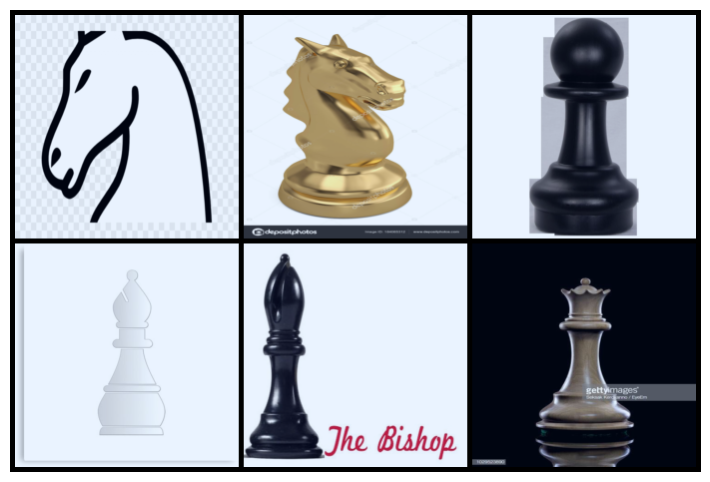

In [14]:
# Check a few images
images = None
labels = None
for batch in train_loader:
    images, labels = batch
    break  # Just take the first batch

# Create a grid of 6 images
grid = torchvision.utils.make_grid(images[:6], nrow=3, padding=5, normalize=True)

# Display the grid of images
plt.figure(figsize=(10, 6))
plt.imshow(np.transpose(grid, (1, 2, 0))) # C,W,H -> W,H,C
plt.axis('off')
plt.show()

## Model

In [15]:
pl.seed_everything(SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [16]:
mdl = models.efficientnet_b0(weights='DEFAULT')
mdl.classifier[1]

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 90.4MB/s]


Linear(in_features=1280, out_features=1000, bias=True)

In [28]:
class FineTuningEfficientNet(pl.LightningModule):
    def __init__(self, num_classes=6, pretrained=True, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.backbone = models.efficientnet_b0(weights='DEFAULT')
        self.backbone.classifier[1] = nn.Linear(self.backbone.classifier[1].in_features, self.hparams.num_classes)
        self.training_accs = []
        self.valid_accs = []
        # self.accuracy = Accuracy(task)

    def forward(self, x):
        return self.backbone(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        # acc = self.accuracy(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().mean().item()
        self.training_accs.append(acc)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        # acc = self.accuracy(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().mean().item()
        self.valid_accs.append(acc)
        self.log('val_loss', loss)
        self.log('val_acc', acc, prog_bar=True)

    def on_train_epoch_end(self):
        # do something with all training_step outputs, for example:
        avg_acc = sum(self.training_accs)/len(self.training_accs)
        # self.log("training_epoch_mean", epoch_mean)
        print(f'Epoch: {self.current_epoch}, Training Accuracy: {avg_acc:.4f}\n')

        # free up the memory
        self.training_accs.clear()

    def on_validation_epoch_end(self):
        # do something with all training_step outputs, for example:
        avg_acc = sum(self.valid_accs)/len(self.valid_accs)
        # self.log("training_epoch_mean", epoch_mean)
        print(f'Epoch: {self.current_epoch}, Valid Accuracy: {avg_acc:.4f}')

        # free up the memory
        self.valid_accs.clear()

    # TODO: fix these
    # def validation_epoch_end(self, outputs):
    #     avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

    # def training_epoch_end(self, outputs):
    #     avg_acc = torch.stack([x['train_acc'] for x in outputs]).mean()
    #     print(f'Epoch: {self.current_epoch}, Training Accuracy: {avg_acc.item():.4f}')


In [29]:
model = FineTuningEfficientNet()

trainer = pl.Trainer(
    max_epochs=50,      # Number of epochs to train for
    accelerator='gpu',
    enable_progress_bar=False,
)

# Train the model
trainer.fit(model, train_loader, valid_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type         | Params
------------------------------------------
0 | backbone | EfficientNet | 4.0 M 
------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.061    Total estimated model params size (MB)


Epoch: 0, Valid Accuracy: 0.1250
Epoch: 0, Valid Accuracy: 0.3683
Epoch: 0, Training Accuracy: 0.2292
Epoch: 1, Valid Accuracy: 0.5379
Epoch: 1, Training Accuracy: 0.5708
Epoch: 2, Valid Accuracy: 0.6473
Epoch: 2, Training Accuracy: 0.7542
Epoch: 3, Valid Accuracy: 0.7567
Epoch: 3, Training Accuracy: 0.8700
Epoch: 4, Valid Accuracy: 0.7879
Epoch: 4, Training Accuracy: 0.8608
Epoch: 5, Valid Accuracy: 0.8237
Epoch: 5, Training Accuracy: 0.9017
Epoch: 6, Valid Accuracy: 0.8237
Epoch: 6, Training Accuracy: 0.9650
Epoch: 7, Valid Accuracy: 0.8237
Epoch: 7, Training Accuracy: 0.9517
Epoch: 8, Valid Accuracy: 0.8036
Epoch: 8, Training Accuracy: 0.9750
Epoch: 9, Valid Accuracy: 0.8393
Epoch: 9, Training Accuracy: 0.9875
Epoch: 10, Valid Accuracy: 0.8036
Epoch: 10, Training Accuracy: 0.9608


In [ ]:
# %tensorboard --logdir logs/


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


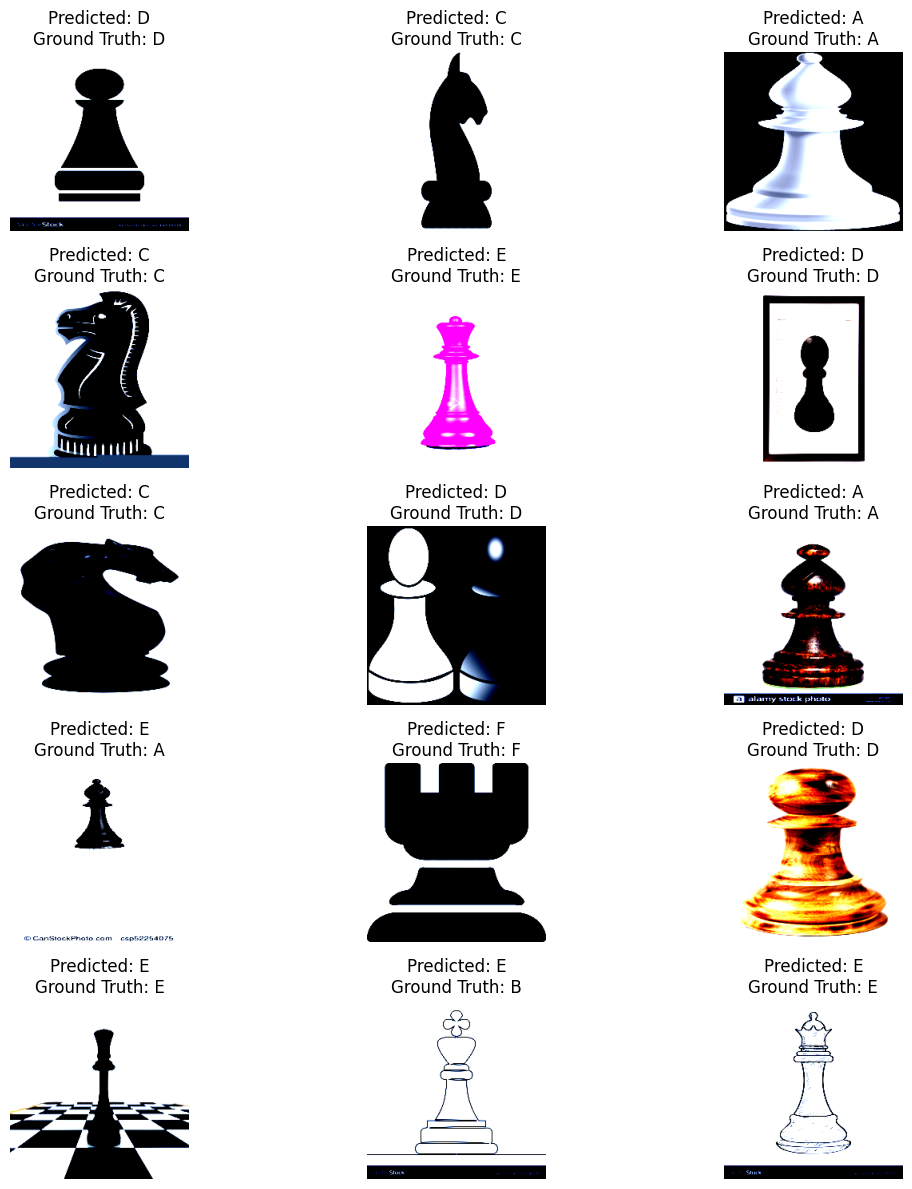

In [30]:
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_predictions(model, test_loader, class_labels):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Get a batch of images and labels from the test loader
        images, labels = next(iter(test_loader))
        images = images.to(device)  # Move images to the device (e.g., GPU)
        labels = labels.numpy()  # Convert labels to numpy array

        # Forward pass to get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()  # Move predictions to CPU and convert to numpy array

        # Plot the images with their predicted and ground truth labels
        fig, axes = plt.subplots(len(images) // 3, 3, figsize=(12, 12))
        for idx, ax in enumerate(axes.flatten()):
            ax.imshow(np.transpose(images[idx].cpu().numpy(), (1, 2, 0)))
            ax.set_title(f"Predicted: {class_labels[predicted[idx]]}\nGround Truth: {class_labels[labels[idx]]}")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

# Usage example:
# Replace `model`, `test_loader`, and `class_labels` with your actual model, test loader, and class labels
class_labels = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
]

plot_predictions(model, test_loader, class_labels)
